In [1]:
using Distributions, StatsPlots, Random

In [2]:
#Initial values
n = 10000; # data size
w = 0.5;
a = 2.0;

In [3]:
#Preparing sample.

realcita = 3.0; #expected mean

gx1 = randn(n) 
for i in 1:n
    gx1[i]+=realcita
end
gx2 = randn(n)*a;
x1 = sample(gx1,Int((1 - w)*n));
x2 = sample(gx2,Int(w*n));
x = randn(n);
for i in 1:n
    if i <= Int(w*n)
        x[i] = x1[i]
    else
        x[i] = x2[i - Int(w*n)]    
    end
end

In [ ]:
#!!!!!!!!!!!
#!!!!!!!!!!!
# Aqui muestro primero un método simple para determinar la media buscada
# a partir de la elimincaión parcial del ruido de una distribucion sobre otra. Más abajo muestro el 
# método clásico utilizando Turing que me imagino que era el que usted esperaba.

In [4]:
linf = findmin(x)[1];
lmax = findmax(x)[1];
div = findmin([a,1.0])[1]/10;
ndiv = Int(floor((lmax-linf)/div)) + 1;

In [5]:
z = zeros(ndiv);
pos = 0;
for i in 1:n
    pos = Int(floor((x[i] - linf)/div)) + 1
    z[pos]+=1
end

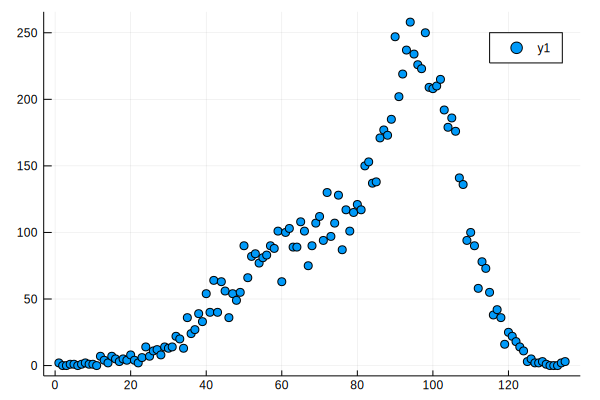

In [6]:
scatter(z) # 2D representation of the number of points for the corresponding interval for the initial data

In [7]:
size = Int(floor(w * n));
kgs = randn(size)*a; # known normal distribution N(0,a)
kz = zeros(ndiv);
pos = 0;
for i in 1:size
    if kgs[i] < lmax && kgs[i] > linf
        pos = Int(floor((kgs[i] - linf)/div)) + 1
        kz[pos]+=1
    end
end

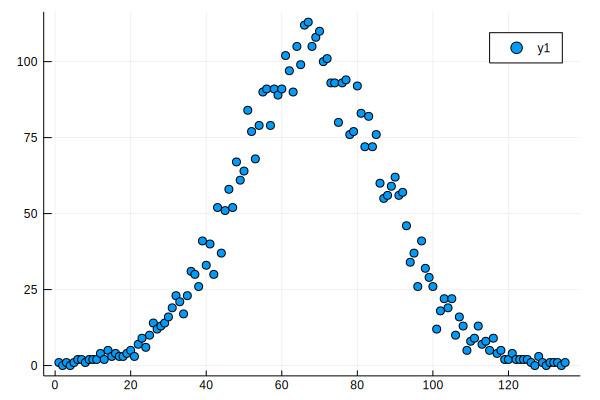

In [8]:
scatter(kz) # sample of the known gaussian distribution N(0,a)

In [9]:
rz = zeros(ndiv);
for i in 1:ndiv
    rz[i] = z[i] - kz[i]
end

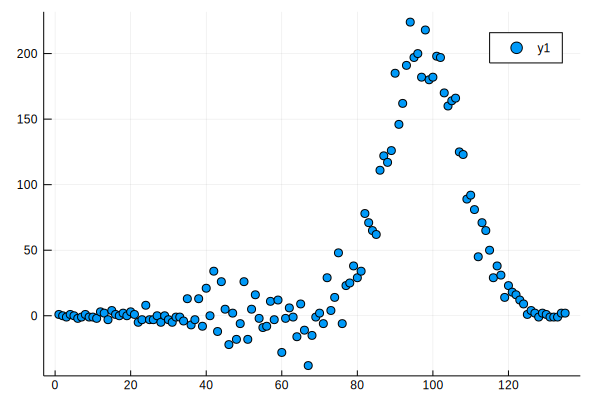

In [10]:
scatter(rz) # eliminating a sample of the known gaussian distribution

In [11]:
result = findmax(rz);
println("estimated mean (first aproximation) = " , result[2]*div + linf) 
println("real mean = " , realcita) 
println("error (first aproximation) = " , abs(abs(realcita - result[2]*div - linf)/realcita)*100 , " %")
#real mean stated in preparing sample, in this case it is 3.0

estimated mean (first aproximation) = 2.679961714862949
real mean = 3.0
error (first aproximation) = 10.667942837901705 %


In [12]:
# Because we also have a knowledge of the sv of the unknown normal distribution we can obtain a better estimate for the mean
msize = Int(4.0/div); # 2 times sv = 1.0 for each side of the max value
meangroup = zeros(msize);
pos = 0
sumgroup = 0
for i in 1:msize
    pos = result[2] - Int(msize/2) + i
    meangroup[i] = rz[pos] * (pos*div + linf)
    sumgroup += rz[pos]
end

In [13]:
result2 = sum(meangroup)/sumgroup;
println("estimated mean (first aproximation) = " , result2) 
println("real mean = " , realcita) 
println("error (first aproximation) = " , abs(abs(realcita - result2)/realcita)*100 , " %")

estimated mean (first aproximation) = 2.978111420497936
real mean = 3.0
error (first aproximation) = 0.7296193167354599 %


In [ ]:
# !!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!
# Este es el método esperado utilizando Turing para w = 0.5

In [15]:
using Turing, MCMCChains

In [16]:
@model GaussianMixtureModel(x) = begin
        a = 2.0
        n = length(x)
        x2 ~ Normal(0,a)
        k = Vector{Int}(undef, n)
        for i = 1:n
            k[i] ~ DiscreteUniform(0,1)
            x[i] ~ Normal(x2*k[i], k[i] + (1-k[i])*a)
        end
        return k
end

GaussianMixtureModel (generic function with 2 methods)

In [53]:
iter = 20
samplesize = 1000
result = sample(GaussianMixtureModel(x[1:samplesize]), SMC(iter));

In [54]:
mgroup = [];
for i = 1:iter
    push!(mgroup,get(result,:x2).x2[i])
end

In [58]:
result =mean(mgroup);
println("estimated mean (Turing 20 iter/ 1000 sample) = " , result) 
println("real mean = " , realcita) 
println("error (Turing 20 iter/ 1000 sample) = " , abs(abs(realcita - result)/realcita)*100 , " %")

estimated mean (Turing 20 iter/ 1000 sample) = 3.4543905326787203
real mean = 3.0
error (Turing 20 iter/ 1000 sample) = 15.146351089290677 %
